# Spherical harmonic spectrum diagrams, using HealPy

---------------

In [1]:
### Import Packages: so many, gathered here 

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

## HEALPix Specific
import healpy as hp
import healpix
import easygems.healpix as egh

import cartopy.crs as ccrs
import cartopy.feature as cf

-------------
# Catalog of hackathon datasets 
--------------

In [2]:
import intake
# catalogue from which node? 
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["NCAR"]

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<Figure size 640x480 with 0 Axes>

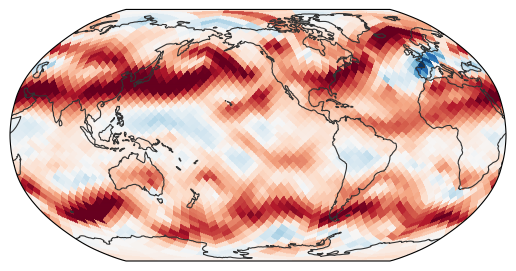

In [3]:
ZOOMLEVEL=4  # mpas_dyamond goes up to 10 

ds = cat.mpas_dyamond2(zoom=ZOOMLEVEL).to_dask()
myfield = ds.uReconstructZonal[1,:,30]

egh.healpix_show(myfield, vmin=-0.05*1000,vmax=0.05*1000,cmap='RdBu_r');  #, cbar=True);

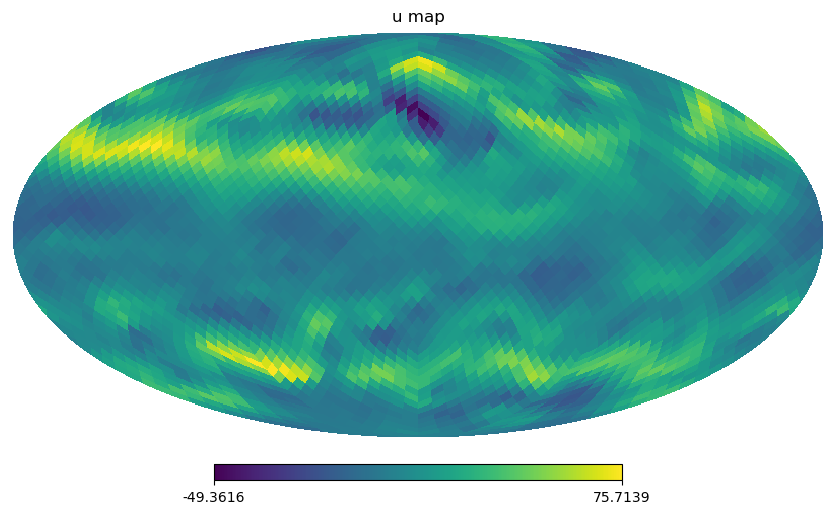

In [4]:
# 1. HealPy plot the data, nest format
hp.mollview(myfield.to_numpy(), nest=True, title="u map")

In [5]:
# def plot_alm_coefficients

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

def plot_alm_coefficients(healpix_map, lmax, mmax=None, zoomlabel=''):
    """
    Plots the absolute values of the spherical harmonic coefficients (alm)
    from a healpix map as a 2D pcolormesh, labeled with zonal and meridional
    wavenumbers.

    Parameters
    ----------
    healpix_map : array-like
        A HEALPix map.
    lmax : int
        Maximum degree l of the spherical harmonic coefficients.
    mmax : int, optional
        Maximum order m of the spherical harmonic coefficients.
        If None, defaults to lmax.
    """
    if mmax is None:
        mmax = lmax

    # Compute the spherical harmonic coefficients.
    alm = hp.map2alm(healpix_map, lmax=lmax, mmax=mmax)

    # Get the l and m values corresponding to the alm coefficients.
    l_values, m_values = hp.Alm.getlm(lmax)

    # Reshape the alm coefficients and l/m values for plotting.
    # The shape will be (lmax + 1, lmax + 1), even if mmax < lmax,
    # but the upper triangle will contain the relevant data.
    alm_matrix = np.zeros((lmax + 1, lmax + 1), dtype=np.complex128)
    abs_alm_matrix = np.zeros((lmax + 1, lmax + 1))
    l_matrix = np.zeros((lmax + 1, lmax + 1), dtype=int)
    m_matrix = np.zeros((lmax + 1, lmax + 1), dtype=int)

    alm_index = 0
    for l in range(lmax + 1):
        for m in range(l + 1):
            alm_matrix[l, m] = alm[alm_index]
            abs_alm_matrix[l, m] = np.abs(alm[alm_index])
            l_matrix[l, m] = l
            m_matrix[l, m] = m
            alm_index += 1

    # Create the plot.
    fig, ax = plt.subplots(figsize=(10, 8))

    # Use pcolormesh to create the 2D plot.  We only plot the upper
    # triangle, which contains the unique information.
    im = ax.pcolormesh(
        np.arange(mmax + 2),  # x-coordinates for columns (m)
        np.arange(lmax + 2),  # y-coordinates for rows (l)
        abs_alm_matrix[:lmax+1, :mmax+1], # The data: abs(alm[l, m])
        cmap='viridis',  # Choose a colormap
        shading='auto'
    )

    # Add a colorbar.
    cbar = fig.colorbar(im, ax=ax, label='$|amplitude|$', extend='max')

    # Set the axis labels.
    ax.set_xlabel('Zonal Wavenumber (m)', fontsize=14)
    ax.set_ylabel('Meridional Wavenumber (l)', fontsize=14)
    ax.set_title('Absolute Values of Spherical Harmonic Coefficients, zoom '+zoomlabel, fontsize=14)

    # Set the tick locations and labels.  We add 0.5 to the locations TOO MANY TICKS 
    # so the labels are centered in the cells.
    #ax.set_xticks(np.arange(mmax + 1) + 0.5)
    #ax.set_xticklabels(np.arange(mmax + 1), fontsize=12)
    #ax.set_yticks(np.arange(lmax + 1) + 0.5)
    #ax.set_yticklabels(np.arange(lmax + 1), fontsize=12)

    # Make sure the plot limits are correct.
    ax.set_xlim(0, mmax + 1)
    ax.set_ylim(0, lmax + 1)
    ax.invert_yaxis()  # Put l=0 at the bottom, as is conventional

    # Add text labels for the l and m values in each cell.  This can
    # be helpful for interpreting the plot, but can make it cluttered
    # for very high lmax/mmax.
    if lmax <= 20: # Don't add labels if its too big
        for l in range(lmax + 1):
            for m in range(l + 1):
                text = ax.text(m + 0.5, l + 0.5, f'{l},{m}',
                               ha='center', va='center', color='white', fontsize=8)

    plt.tight_layout()
    plt.show()

In [7]:
# Spherical harmonic computation in l (total) and m (zonal) wavenumbers 
my_map = myfield.to_numpy()

nside = hp.get_nside(my_map)
lmax = 3 * nside - 1
kmax = lmax

# Compute the spherical harmonic coefficients (alm)
alm = hp.map2alm(my_map, lmax=lmax, mmax=kmax)

In [8]:
# Coordinates k, l and 2D array spec = alm 
l_vals, k_vals = hp.Alm.getlm(lmax)

# Reshape the alm coefficients and l/m values for plotting.
# The shape will be (lmax + 1, lmax + 1), even if mmax < lmax,
# but the upper triangle will contain the relevant data.
alm_matrix = np.zeros((lmax + 1, lmax + 1), dtype=np.complex128)
abs_alm_matrix = np.zeros((lmax + 1, lmax + 1))
l_matrix = np.zeros((lmax + 1, lmax + 1), dtype=int)
m_matrix = np.zeros((lmax + 1, lmax + 1), dtype=int)

alm_index = 0
for l in range(lmax + 1):
    for m in range(l + 1):
        alm_matrix[l, m] = alm[alm_index]
        abs_alm_matrix[l, m] = np.abs(alm[alm_index])
        l_matrix[l, m] = l
        m_matrix[l, m] = m
        alm_index += 1

sspec = np.zeros((lmax + 1, kmax + 1))
for i in range(alm.size):
    if k_vals[i] >= 0: # only plot for positive (nonzero) m or k
        sspec[l_vals[i], k_vals[i]] = alm[i]
        

/glade/derecho/scratch/mapes/tmp/ipykernel_19820/841266237.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  sspec[l_vals[i], k_vals[i]] = alm[i]


# Healpy spherical transform code (per Gemini)

In [10]:
# spherical spectrum plot 

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

def plot_alm(alm, lmax, title="Spherical Harmonic Coefficients"):

    l_vals, m_vals = hp.Alm.getlm(lmax)
    abs_alm = np.zeros((lmax + 1, lmax + 1))
    for i in range(alm.size):
        if m_vals[i] >= 0: # only plot for positive m
            abs_alm[l_vals[i], m_vals[i]] = np.abs(alm[i])

    plt.figure(figsize=(4, 3))
    plt.pcolormesh(np.log(abs_alm), cmap='viridis', shading='auto')
    plt.xlabel('Zonal Wavenumber (m)')
    plt.ylabel('Meridional Wavenumber (l)')
    plt.title(title)
    plt.colorbar(label='$log(amplitude)$', extend='max')
    plt.tight_layout()
    plt.show()

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/glade/derecho/scratch/mapes/tmp/ipykernel_19820/436748875.py:16: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(np.log(abs_alm), cmap='viridis', shading='auto')


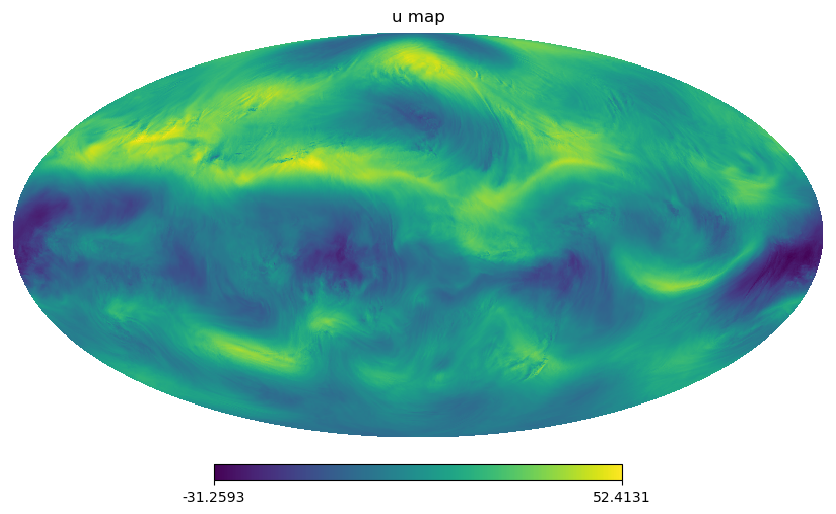

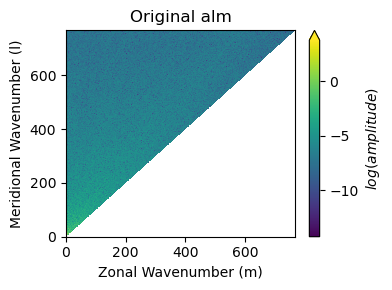

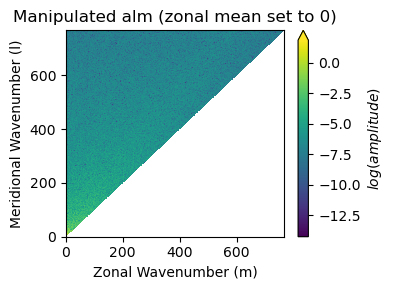

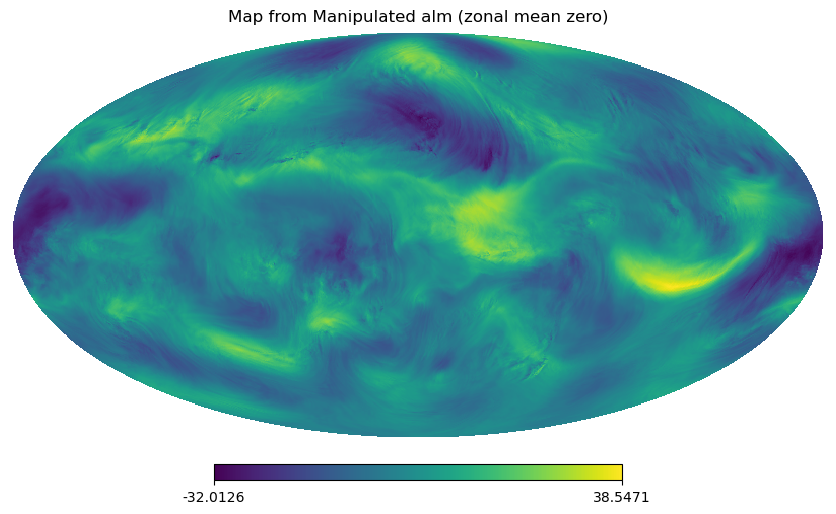

In [11]:
# Okay, let's remove the zonal mean as a test 

ZOOMLEVEL=8  # mpas_dyamond goes up to 10 

ds = cat.mpas_dyamond2(zoom=ZOOMLEVEL).to_dask()
my_map = ds.uReconstructZonal[1,:,40].to_numpy()
hp.mollview(my_map, nest=True, title="u map")

# 2. Compute the spherical harmonic coefficients.

# Convert to ring order 
map_data_ring = hp.reorder(my_map, n2r=True)      # to Ring ordering 
nside = hp.get_nside(map_data_ring)
lmax = 3 * nside - 1; mmax = lmax
alm = hp.map2alm(map_data_ring, lmax=lmax)

# 3. Plot the original alm
plot_alm(alm, lmax, title="Original alm")

# 4. Manipulate the alm coefficients (example: set m=0 to zero).
l_vals, m_vals = hp.Alm.getlm(lmax)
manipulated_alm = alm.copy() # Create a copy to avoid modifying the original
manipulated_alm[m_vals == 0] = 0
plot_alm(manipulated_alm, lmax, title="Manipulated alm (zonal mean set to 0)")

# 5. Visualize the resulting map from manipulated alm 
hp.mollview(hp.alm2map(manipulated_alm, nside, lmax=lmax), title="Map from Manipulated alm (zonal mean zero)")

In [49]:
def plot_map_and_alm(alm, nside, lmax, titles=None):
    from matplotlib.colors import LogNorm
    
    fig = plt.figure(figsize=(18, 7))
    
    # Left subplot: Map
    ax1 = fig.add_subplot(121)
    map_data = hp.alm2map(alm, nside, lmax=lmax)
    
    # Calculate the mollview projection manually without plotting
    hp.disable_warnings()  # Prevent healpy warnings
    orig_rcParams = dict(plt.rcParams)  # Save current params
    
    # Save current figure and create a temporary one
    current_fig = plt.gcf()
    temp_fig = plt.figure(figsize=(8, 8))
    
    # Get mollview data
    ret = hp.mollview(map_data, hold=True, return_projected_map=True)
    
    # Close temporary figure
    plt.close(temp_fig)
    
    # Restore original figure
    plt.figure(fig.number)
    
    # Plot on our actual subplot
    im = ax1.imshow(ret, origin='lower')
    ax1.axis('off')
    if titles and len(titles) > 0:
        ax1.set_title(titles[0])
    
    # Right subplot: ALM coefficients
    ax2 = fig.add_subplot(122)
    
    # Extract l, m, power values
    l_vals, m_vals, powers = [], [], []
    for l in range(lmax + 1):
        for m in range(0, l + 1):
            idx = hp.Alm.getidx(lmax, l, m)
            l_vals.append(l)
            m_vals.append(m)
            powers.append(np.abs(alm[idx])**2)
    
    scatter = ax2.scatter(m_vals, l_vals, c=powers, s=15, 
                         cmap='viridis', norm=LogNorm())
    
    ax2.set_xlabel('m (Zonal Wavenumber)')
    ax2.set_ylabel('l (Total Wavenumber)')
    if titles and len(titles) > 1:
        ax2.set_title(titles[1])
    
    plt.colorbar(scatter, ax=ax2, label='Power')
    plt.tight_layout()
    
    return fig

/glade/derecho/scratch/mapes/tmp/ipykernel_19820/1423284677.py:11: HealpyDeprecationWarning: The disable_warnings function is deprecated and may be removed in a future version.
  hp.disable_warnings()  # Prevent healpy warnings


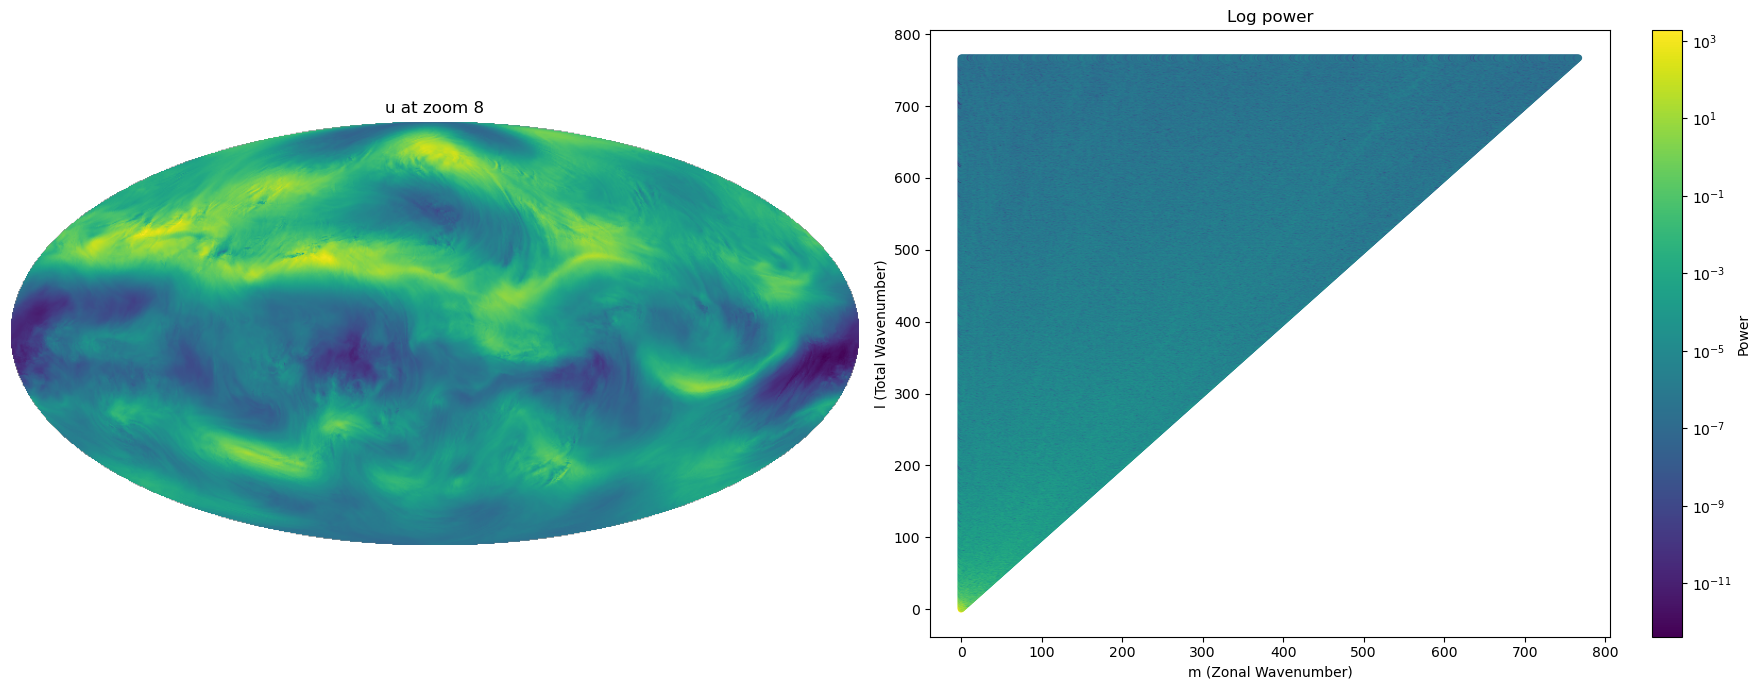

In [63]:
# Example usage:
manipulated_alm = alm.copy() # Create a copy to avoid modifying the original
titles = ["u at zoom 8", "Log power"]
myfig=plot_map_and_alm(manipulated_alm, nside, lmax, titles)

/glade/derecho/scratch/mapes/tmp/ipykernel_19820/1423284677.py:11: HealpyDeprecationWarning: The disable_warnings function is deprecated and may be removed in a future version.
  hp.disable_warnings()  # Prevent healpy warnings


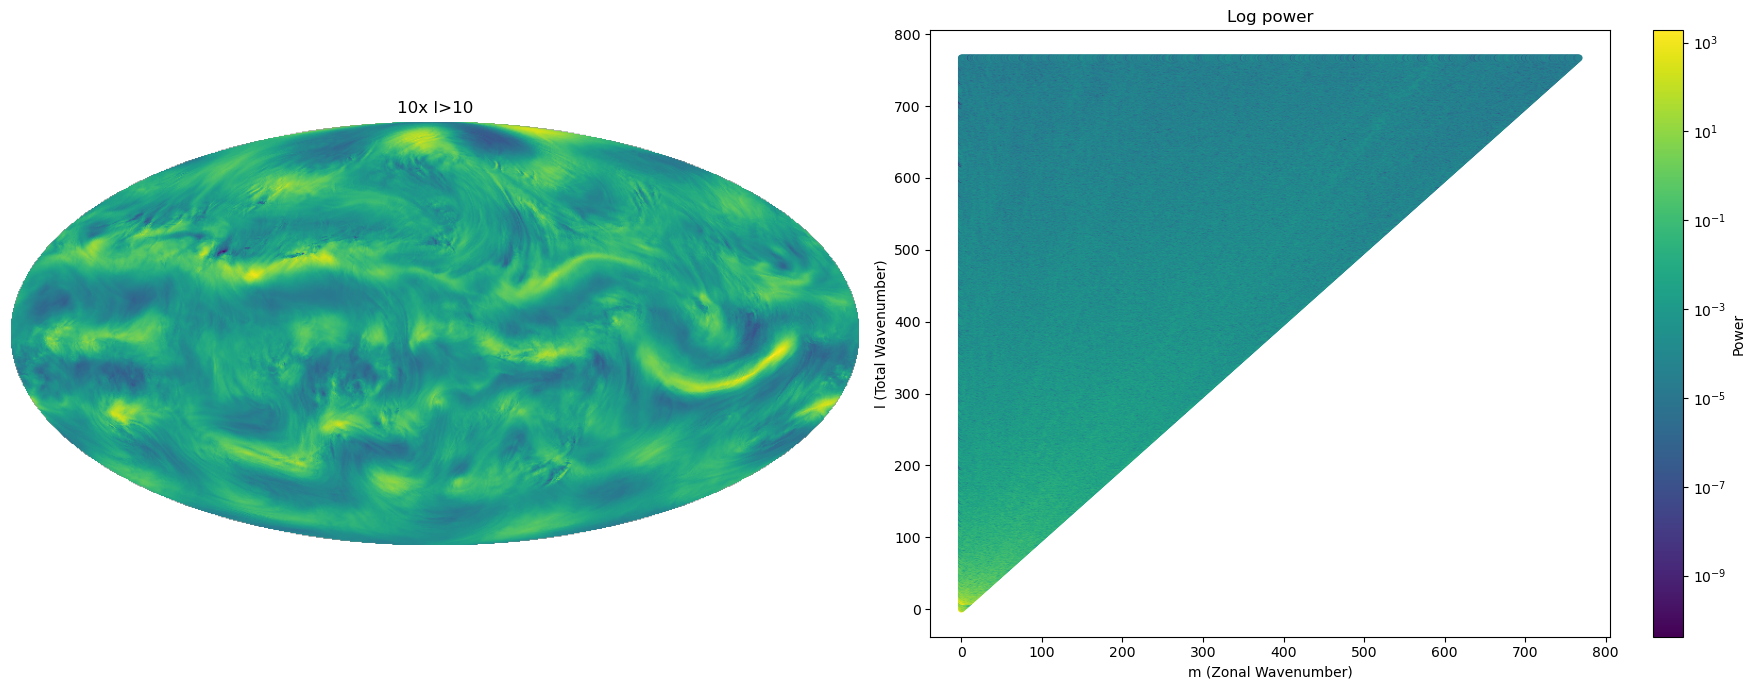

In [66]:
manipulated_alm = alm.copy() # Create a copy to avoid modifying the original
manipulated_alm[(l_vals > 10)] *= 10; titles[0]='10x l>10'
myfig=plot_map_and_alm(manipulated_alm, nside, lmax, titles)

/glade/derecho/scratch/mapes/tmp/ipykernel_19820/1423284677.py:11: HealpyDeprecationWarning: The disable_warnings function is deprecated and may be removed in a future version.
  hp.disable_warnings()  # Prevent healpy warnings


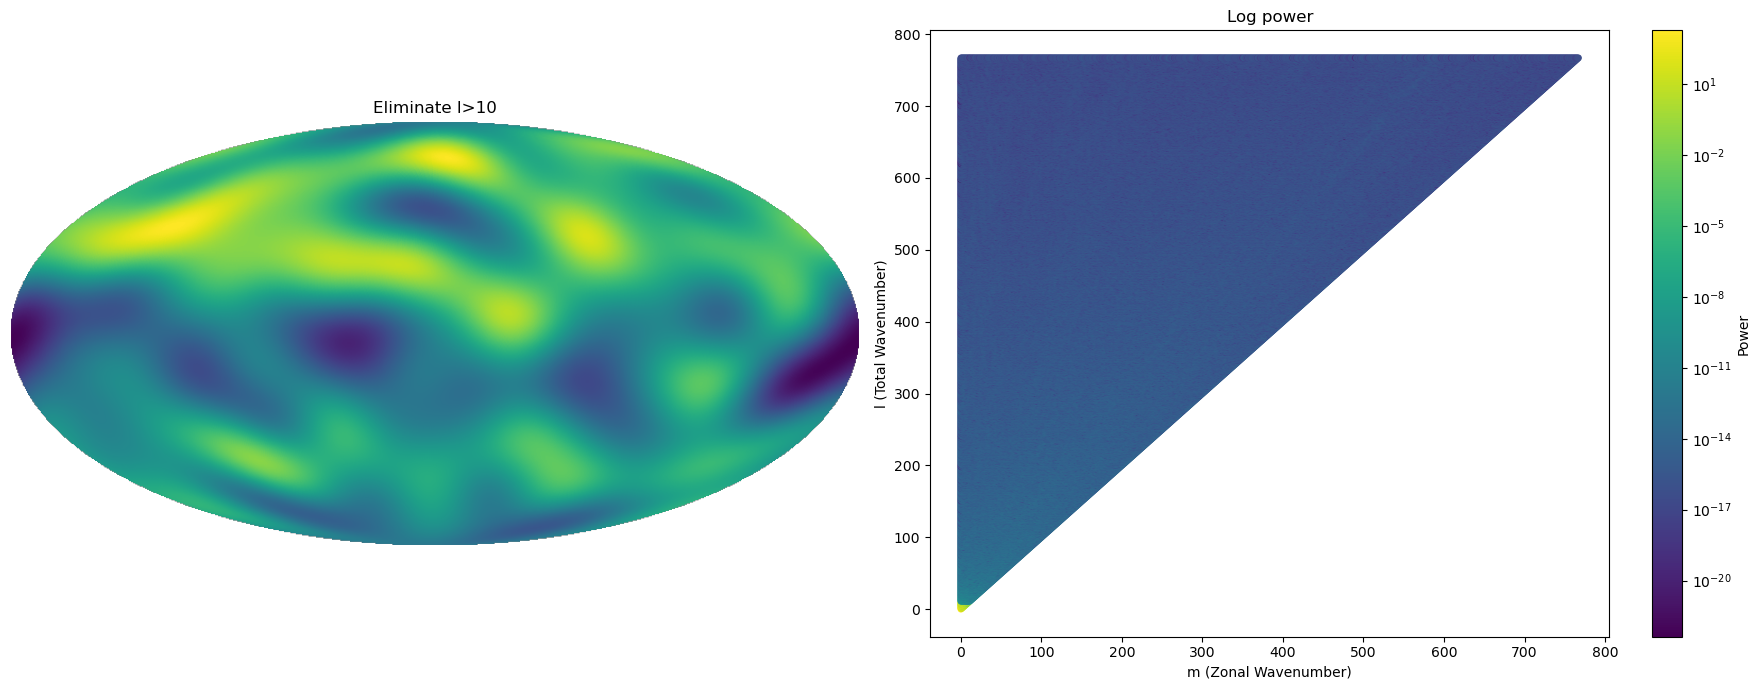

In [69]:
manipulated_alm = alm.copy() # Create a copy to avoid modifying the original
manipulated_alm[(l_vals > 10)] *= 1e-5; titles[0]='Eliminate l>10'
myfig=plot_map_and_alm(manipulated_alm, nside, lmax, titles)

/glade/derecho/scratch/mapes/tmp/ipykernel_19820/1423284677.py:11: HealpyDeprecationWarning: The disable_warnings function is deprecated and may be removed in a future version.
  hp.disable_warnings()  # Prevent healpy warnings


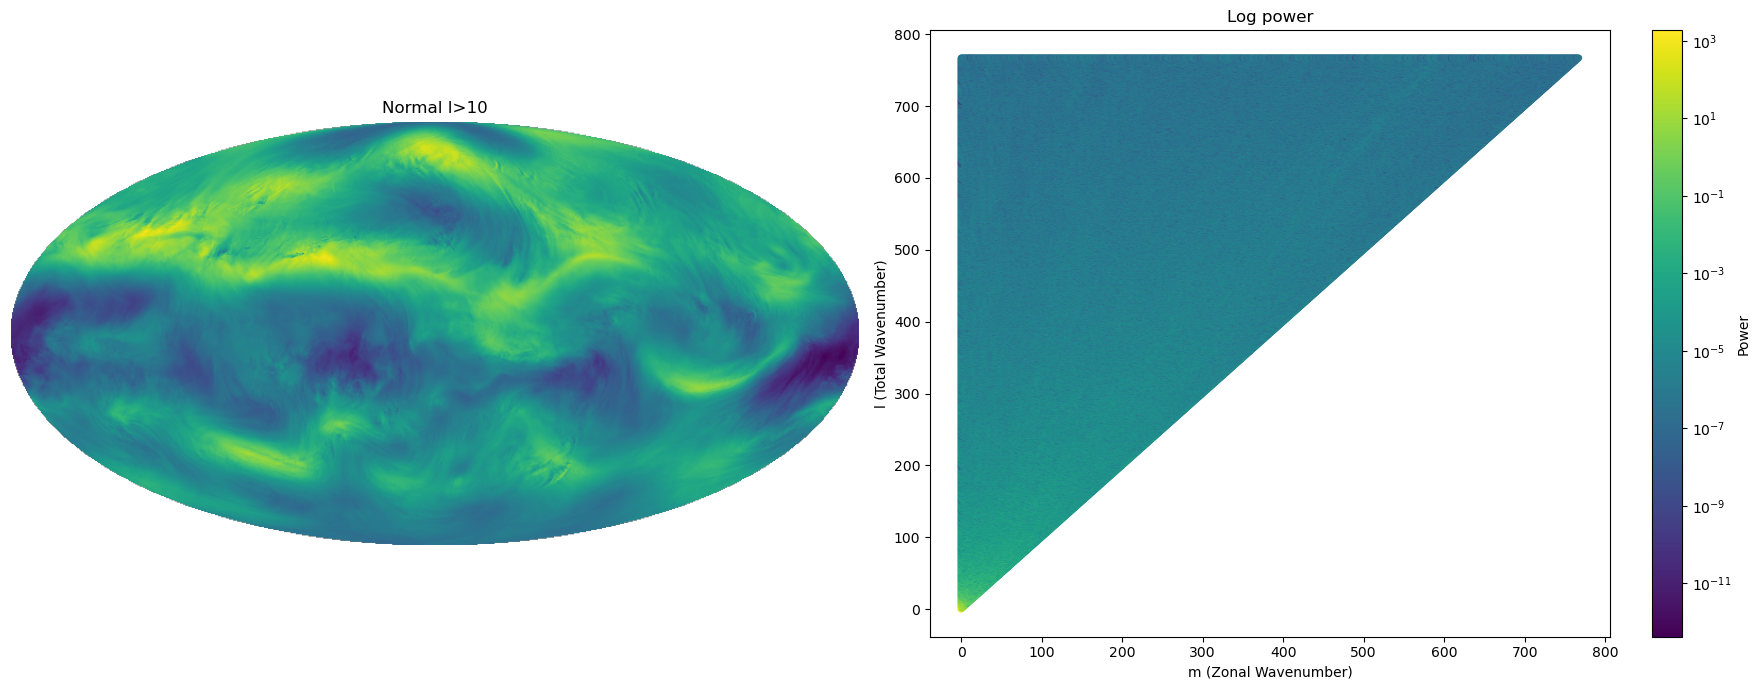

In [68]:
manipulated_alm = alm.copy() # Create a copy to avoid modifying the original
manipulated_alm[(l_vals > 10)] *= 1; titles[0]='Normal l>10'
myfig=plot_map_and_alm(manipulated_alm, nside, lmax, titles)

# Gravity wave phase speed spectrum from w map pairs

In [28]:
# To use this with HealPy, on a sequence of w maps: 
import healpy as hp

ZOOMLEVEL=8  # mpas_dyamond goes up to 10 
ds = cat.mpas_dyamond2(zoom=ZOOMLEVEL).to_dask()
w_maps = ds.w[1:3,:,20].to_numpy()


/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


/glade/derecho/scratch/mapes/tmp/ipykernel_19820/1971252362.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


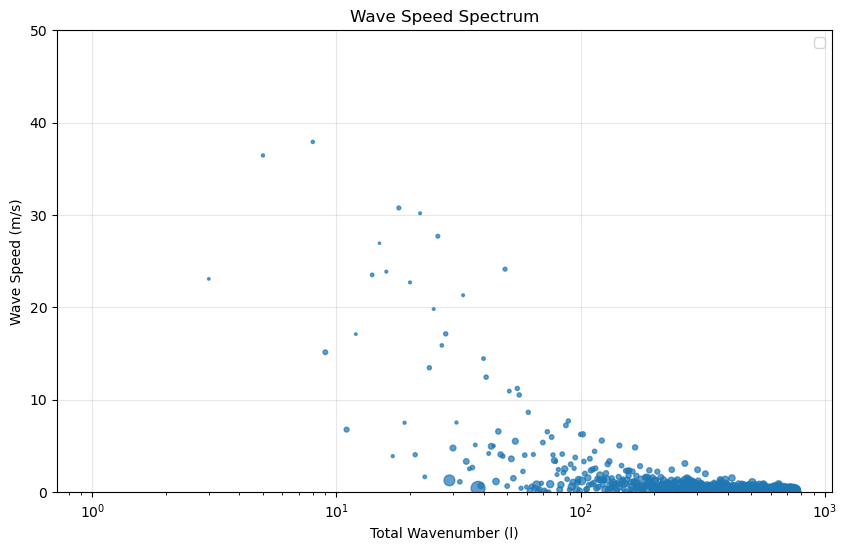

In [70]:
def compute_wave_speeds(w_maps, dt, lmax, r_planet=6371e3):
    """Calculate wave speeds from raw maps, preserving all phase information"""
    l_values = np.arange(1, lmax+1)
    speeds = np.zeros(lmax)
    powers = np.zeros(lmax)
    
    # For each consecutive pair
    for i in range(len(w_maps) - 1):
        # Convert maps to alms (preserving phase)
        alm1 = hp.map2alm(w_maps[i], lmax=lmax)
        alm2 = hp.map2alm(w_maps[i+1], lmax=lmax)
        
        # For each l, extract phase differences
        for l in l_values:
            l_phase_diffs = []
            l_powers = []
            
            # For each m
            for m in range(0, l+1):  # HEALPy only stores m>=0
                idx = hp.Alm.getidx(lmax, l, m)
                
                # Get phase of each time step
                phase1 = np.angle(alm1[idx])
                phase2 = np.angle(alm2[idx])
                
                # Calculate phase difference
                phase_diff = (phase2 - phase1) % (2*np.pi)
                if phase_diff > np.pi:
                    phase_diff = phase_diff - 2*np.pi
                
                # Power for weighting
                power = np.abs(alm1[idx] * np.conjugate(alm2[idx]))
                
                l_phase_diffs.append(phase_diff)
                l_powers.append(power)
            
            # Calculate weighted average phase difference for this l
            if sum(l_powers) > 0:
                avg_phase_diff = np.sum(np.array(l_phase_diffs) * np.array(l_powers)) / np.sum(l_powers)
                
                # Convert to frequency
                freq = avg_phase_diff / dt
                
                # Convert to speed
                k = l / r_planet
                speed = abs(freq / k)  # Take absolute value for magnitude
                
                # Accumulate
                speeds[l-1] += speed
                powers[l-1] += sum(l_powers)
    
    # Average over all pairs
    speeds /= (len(w_maps) - 1)
    powers /= (len(w_maps) - 1)
    
    return l_values, speeds, powers

# Use this more direct approach
l_values, speeds, powers = compute_wave_speeds(w_maps, dt, lmax)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(l_values, speeds, s=powers/np.max(powers)*100, alpha=0.7)
#plt.axhline(y=c_theory, color='r', linestyle='--', 
#           label=f'Theoretical speed c = {c_theory:.1f} m/s')
plt.xlabel('Total Wavenumber (l)')
plt.ylabel('Wave Speed (m/s)')
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.title('Wave Speed Spectrum')
plt.ylim([0,50])
plt.legend()

In [30]:
def compute_wave_speed_spectrum(cross_alms, dt, lmax, r_planet=6371e3):
    """Calculate wave speed using phase of cross-alms directly"""
    l_values = np.arange(1, lmax+1)  # Skip l=0
    speeds = np.zeros(lmax)
    powers = np.zeros(lmax)
    
    # Average over all pairs by summing cross_alms
    avg_cross_alm = np.zeros_like(cross_alms[0])
    for cross_alm in cross_alms:
        avg_cross_alm += cross_alm
    avg_cross_alm /= len(cross_alms)
    
    # For each l, extract all m coefficients and compute average phase
    for l in l_values:
        l_phases = []
        l_powers = []
        
        # Loop through all valid m values for this l
        for m in range(-l, l+1):
            if m < 0:
                continue  # Skip negative m (redundant in healpy's storage)
                
            # Get index in alm array
            idx = hp.sphtfunc.Alm.getidx(lmax, l, m)
            
            # Extract power and phase
            power = np.abs(avg_cross_alm[idx])**2
            phase = np.angle(avg_cross_alm[idx])
            
            l_phases.append(phase)
            l_powers.append(power)
        
        # Weighted average phase for this l
        if l_powers:
            total_power = sum(l_powers)
            if total_power > 0:
                # Use absolute phase for speed magnitude
                weighted_phase = sum(abs(ph)*pw for ph, pw in zip(l_phases, l_powers)) / total_power
                
                # Convert phase to angular frequency
                freq = weighted_phase / dt  # radians per second
                
                # Convert to physical speed
                k = l / r_planet  # wavenumber in 1/m
                speeds[l-1] = freq / k  # m/s
                powers[l-1] = total_power
    
    return l_values, speeds, powers

# Plot the results
def plot_wave_speed_spectrum(l_values, speeds, power, c_theory=None):
    plt.figure(figsize=(10, 6))
    
    # Size points by spectral power
    sizes = power / np.max(power) * 100
    
    plt.scatter(l_values, speeds, s=sizes, alpha=0.7)
    
    if c_theory is not None:
        plt.axhline(y=c_theory, color='r', linestyle='--', 
                   label=f'Theoretical speed c = {c_theory} m/s')
    
    plt.xlabel('Total Wavenumber (l)')
    plt.ylabel('Wave Speed (m/s)')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    plt.title('Wave Speed Spectrum')
    plt.legend()

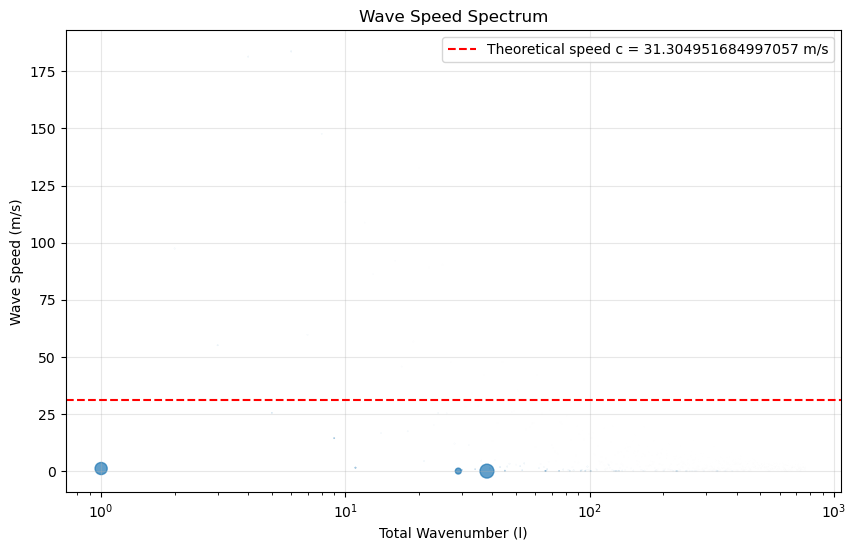

In [31]:
# Modified code to use these functions: 

cross_alms = []
for i in range(len(w_maps) - 1):
    # For two consecutive maps
    alm1 = hp.map2alm(w_maps[i], lmax=lmax)
    alm2 = hp.map2alm(w_maps[i+1], lmax=lmax)
    
    # Cross-spectrum (preserve complex values)
    cross_alm = alm1 * np.conjugate(alm2)
    cross_alms.append(cross_alm)

# Compute speed spectrum directly from cross_alms
l_values, speeds, powers = compute_wave_speed_spectrum(cross_alms, dt, lmax)

plot_wave_speed_spectrum(l_values, speeds, power, c_theory)